In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch


In [2]:
def preprocess_image_with_edges(frame):
    # Convert to grayscale if frame is color
    if len(frame.shape) == 3:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    # Apply bilateral filtering for noise reduction and edge preservation
    smoothed = cv2.bilateralFilter(gray, 9, 75, 75)  # d=9, sigmaColor=75, sigmaSpace=75
    
    # Enhance contrast with CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(smoothed)
    
    # Use Canny edge detection with adaptive thresholding
    edges = cv2.Canny(enhanced, 50, 150)  # Adjust thresholds as needed
    
    # Morphological operations to clean edges
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    edges = cv2.erode(edges, kernel, iterations=1)
    
    return frame, edges  # Return original frame and edges for consistency

def get_grid_position(width, height, center_x, center_y, grid_size=10):
    # Divide the image into a grid_size x grid_size grid
    grid_width = width // grid_size
    grid_height = height // grid_size
    
    # Calculate grid cell (row, column) based on center coordinates
    row = center_y // grid_height
    col = center_x // grid_width
    
    # Ensure row and col are within bounds
    row = min(max(0, row), grid_size - 1)
    col = min(max(0, col), grid_size - 1)
    
    return row, col

def detect_pothole_in_image(model, image_path, scale_factor=0.1, grid_size=10):
    # Preprocess the image
    original_image, edges = preprocess_image_with_edges(cv2.imread(image_path))
    
    # Load and predict with YOLOv8
    results = model(image_path, conf=0.5)  # Confidence threshold of 0.5
    
    # Convert BGR to RGB for display
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    pothole_detected = False
    image_width, image_height = rgb_image.shape[1], rgb_image.shape[0]
    
    for result in results:
        boxes = result.boxes  # Get bounding boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)  # Convert to CPU and int
            conf = box.conf.cpu().numpy()[0]  # Confidence score
            
            if conf >= 0.5:  # Ensure confidence threshold
                pothole_detected = True
                print(f"Pothole Detected with confidence {conf:.2f}!")
                
                # Calculate width and height in pixels
                w = x2 - x1
                h = y2 - y1
                
                # Calculate dimensions in cm (adjust scale_factor based on image resolution and real-world distance)
                width_cm = w * scale_factor
                height_cm = h * scale_factor
                
                # Calculate position (center coordinates in pixels)
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                
                # Get grid position (row, column) in a 10x10 grid
                grid_row, grid_col = get_grid_position(image_width, image_height, center_x, center_y, grid_size)
                
                # Draw bounding box and text
                cv2.rectangle(rgb_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                text = f'Pothole: {width_cm:.2f}cm x {height_cm:.2f}cm\nGrid Position: Row {grid_row}, Col {grid_col}'
                cv2.putText(rgb_image, text, (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    if not pothole_detected:
        print("No Pothole Detected.")
        cv2.putText(rgb_image, 'No Pothole', (50, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display the result
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_image)
    plt.title('Pothole Detection Result')
    plt.axis('off')
    plt.show()

    # Optionally save the annotated image
    output_path = 'pothole_detection_result.jpg'
    cv2.imwrite(output_path, cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR))
    print(f"Annotated image saved as {output_path}")

In [3]:
def detect_potholes_in_video(model, video_path, output_path='pothole_detection_output.avi', scale_factor=0.1, grid_size=10):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file at {video_path}")
        return
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Define the codec and create VideoWriter object to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use 'MJPG' or other codecs
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        
        frame_count += 1
        print(f"Processing frame {frame_count}")
        
        # Preprocess the frame
        original_frame, edges = preprocess_image_with_edges(frame)
        # No need to reshape for YOLOv8, as it handles raw frames directly
        
        # Predict if a pothole is present
        results = model(frame, conf=0.5)  # YOLOv8 prediction on the raw frame (BGR)
        
        # Convert BGR frame to RGB for display and processing
        rgb_frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)
        
        pothole_detected = False
        
        for result in results:
            boxes = result.boxes  # Get bounding boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                conf = box.conf.cpu().numpy()[0]
                
                if conf >= 0.5:
                    pothole_detected = True
                    print(f"Frame {frame_count}: Pothole Detected with confidence {conf:.2f}!")
                    
                    # Calculate width and height in pixels
                    w = x2 - x1
                    h = y2 - y1
                    
                    # Calculate dimensions in cm
                    width_cm = w * scale_factor
                    height_cm = h * scale_factor
                    
                    # Calculate position (center coordinates in pixels)
                    center_x = (x1 + x2) // 2
                    center_y = (y1 + y2) // 2
                    
                    # Get grid position (row, column) in a 10x10 grid
                    grid_row, grid_col = get_grid_position(frame_width, frame_height, center_x, center_y, grid_size)
                    
                    # Draw bounding box and text
                    cv2.rectangle(rgb_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    text = f'Pothole: {width_cm:.2f}cm x {height_cm:.2f}cm\nGrid Position: Row {grid_row}, Col {grid_col}'
                    cv2.putText(rgb_frame, text, (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        if not pothole_detected:
            cv2.putText(rgb_frame, 'No Pothole', (50, 50),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Convert back to BGR for OpenCV output and writing to video
        annotated_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)
        
        # Write the annotated frame to the output video
        out.write(annotated_frame)
    
    # Release resources
    cap.release()
    out.release()
    print(f"Annotated video saved as {output_path}")


image 1/1 c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\pothole.jpg: 416x640 (no detections), 155.5ms
Speed: 10.3ms preprocess, 155.5ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)
No Pothole Detected.


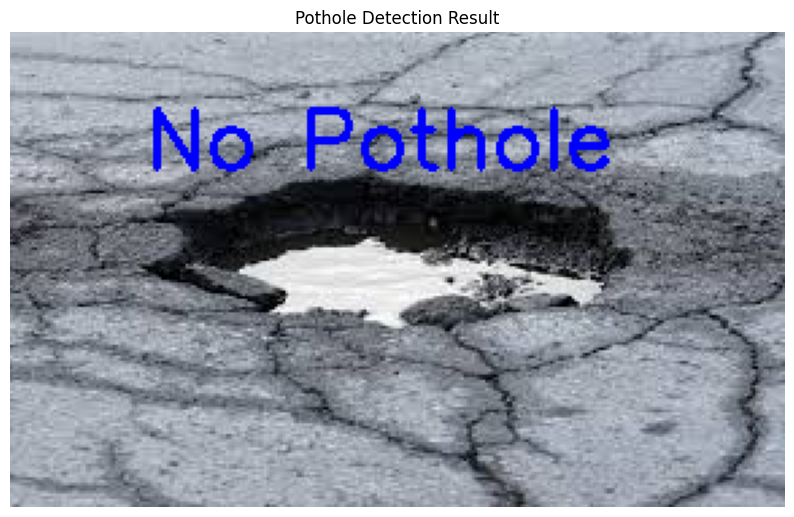

Annotated image saved as pothole_detection_result.jpg


In [4]:
# Load the pre-trained YOLOv8 model (replace with your trained model's path)
best_model = YOLO('runs/train/pothole_detection/weights/best.pt')  # Update this path if different

# Process a single image
image_path = 'pothole.jpg'  # Replace with the path to your image (e.g., 'pothole_image.jpg')
detect_pothole_in_image(best_model, image_path, scale_factor=0.1, grid_size=10)

In [5]:
# Process a video
video_path = 'demo.mp4'  # Replace with the path to your video file (e.g., 'demo.mp4')
detect_potholes_in_video(best_model, video_path, scale_factor=0.1, grid_size=10)

Processing frame 1

0: 384x640 (no detections), 78.7ms
Speed: 2.4ms preprocess, 78.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 2

0: 384x640 (no detections), 55.3ms
Speed: 1.8ms preprocess, 55.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 3

0: 384x640 (no detections), 52.8ms
Speed: 1.9ms preprocess, 52.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 4

0: 384x640 (no detections), 58.0ms
Speed: 1.9ms preprocess, 58.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 5

0: 384x640 (no detections), 56.1ms
Speed: 1.6ms preprocess, 56.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 6

0: 384x640 (no detections), 56.0ms
Speed: 1.4ms preprocess, 56.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 7

0: 384x640 (no detections), 56.6ms
Speed: 1.5ms preprocess, 56.6ms i